# Vulnerability Analysis and Defense Generation using AIShield SDK
* <b>File Name</b>                          : Tutorial_AIShield_Tensorflow_Image_Classification.ipynb
* <b>Date of creation(dd-mm-yyyy)</b>       : 19-12-2022
* <b>Author Name/Dept</b>                   : AIShield
* <b>Organization</b>                       : BGSW
* <b>Description</b>                        : Source Code of Reference Implementation
* <b>Copyright</b>                          : Copyright 2022 Bosch Global Software Technologies Private Limited. All Rights Reserved.

### Input
This Example does the following:
* Downloads the MNIST-Dataset from Tensorflow-Datasets
* Trains a Tensorflow Model for Image Classification on the MNIST Dataset
* Trained Model File : "_mnist_model.h5_"

### Output and Artifacts
1. Vulnerability report
2. Defense report
3. Defense model
4. attack samples

In [1]:
# # Install AIShield SDK.
# # If not already installed, install by uncommenting the code below
!pip install aishield

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# `Prerequisites for Reference Implementation` 

1. Jupyter Notebook
2. Python 3.X
3. matplotlib 3.5.1
4. numpy 1.22.3
5. opencv-python 4.5.5.64
6. pandas 1.4.1
7. scikit-learn 1.0.2
8. tensorflow 2.9.1
9. zipp 3.7.0
10. requests 2.28.0

In [ ]:
!pip install -r requirements.txt

# `1.0 Import Libraries`

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, optimizers , Sequential
from sklearn.model_selection import train_test_split
import zipfile 
import pandas as pd
import cv2
import os
import random
import requests
import json
import time
import shutil

#importing AIShield Library
import aishield as ais

# `2.0 Data Loading and Preprocessing`

### `Loading MNIST Dataset` 


In [3]:
(X_train,y_train),(X_test,y_test)=datasets.mnist.load_data()

### `Splitting Data into Training and Validation Data` 


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,stratify = y_train,test_size = 0.1,random_state = 42)

### `Checking size of the datasets` 


In [5]:
print("shape of x_train: ",X_train.shape)
print("shape of y_train: {}".format(y_train.shape))
print(f'shape of x_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')
print(f'shape of x_val: {X_val.shape}')
print(f'shape of y_val: {y_val.shape}')

shape of x_train:  (54000, 28, 28)
shape of y_train: (54000,)
shape of x_test: (10000, 28, 28)
shape of y_test: (10000,)
shape of x_val: (6000, 28, 28)
shape of y_val: (6000,)


### `Visualizing few random data samples` 


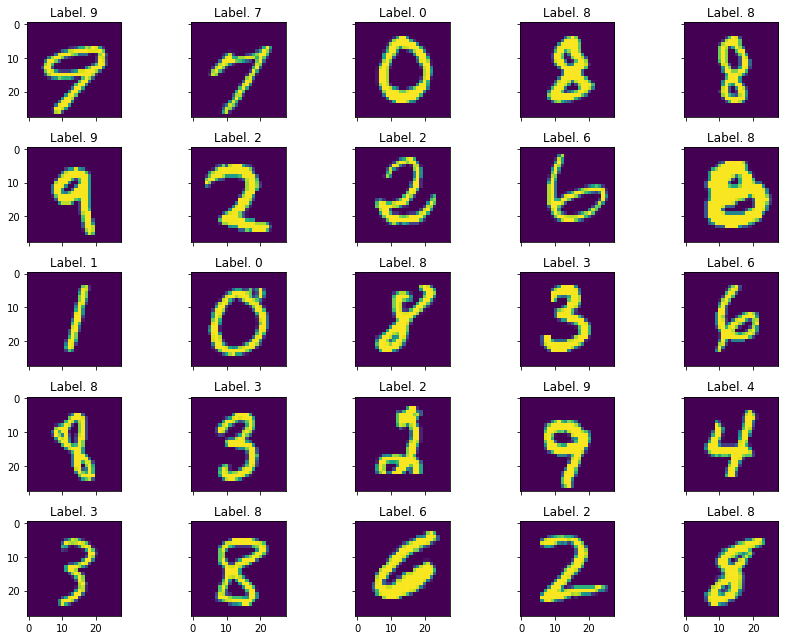

In [6]:
rows=5

random_indices=random.sample(range(X_train.shape[0]),rows*rows)
sample_images=X_train[random_indices,:]
sample_labels=y_train[random_indices]

fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(12,9),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(sample_images[i,:])
    axs[subplot_row,subplot_col].set_title("Label. %d" % sample_labels[i])
plt.tight_layout()

### `Setting values for Number of Classes and Input Shape` 


In [7]:
img_row,img_col,channel=28,28,1
num_classes=10
input_shape=(img_row,img_col,channel)

### `Normalizing and Reshaping the Data` 


In [8]:
X_train = X_train.reshape(-1,*input_shape)/255.0
X_val =  X_val.reshape(-1,*input_shape)/255.0
X_test =  X_test.reshape(-1,*input_shape)/255.0

### `Convert the Labels to one hot encoder` 


In [9]:
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

# `3.0 Model Development and Training`

In [10]:
def make_directory(directory):
    """
    Create directory

    Parameters
    ----------
    directorys : list containing the directory's path to create 
    
    Returns
    -------
    None.

    """
    for d in directory:
        if os.path.isdir(d):
            print("directory {} already exist".format(d))
        if os.path.isdir(d)==False:
            os.mkdir(path=d)
            print("directory {} created successfully".format(d))

In [11]:
def delete_directory(directorys):
    """
    Delete directory 

    Parameters
    ----------
    directorys : list containing the directory's path to delete along with all the files

    Returns
    -------
    None.

    """
    if len(directorys)>=1:
        for d in directorys:
            if os.path.isdir(d):
                try:
                    if os.path.isfile(d):
                        os.remove(path=d)
                    else:
                        shutil.rmtree(path=d)
                        print("Removed: {}".format(d))
                except:
                    print("Failed to removed: {}".format(d))
            else:
                print("Failed to removed: {}".format(d))
                

In [12]:
def make_archive(base_name,root_dir,zip_format='zip'):
    """
    Creates zip for given folder

    Parameters
    ----------
    base_name : name of zip file
    root_dir : directory to archive/zip
    zip_format : zip or tar 
        DESCRIPTION. The default is 'zip'.

    Returns
    -------
    None.

    """
    shutil.make_archive(base_name=base_name, format=zip_format, root_dir=root_dir)
    

### `Creating Data, Model and Label Folder` 


In [13]:
data_path=os.path.join(os.getcwd(),"data")
model_path=os.path.join(os.getcwd(),"model")
label_path=os.path.join(os.getcwd(),"label")

#Create Zip Path which contains data , model and label zip files
zip_path=os.path.join(os.getcwd(),"zip2")

#deleting previously generated folders
delete_directory(directorys=[data_path,model_path,label_path,zip_path])

#creating folders
make_directory([data_path,model_path,label_path,zip_path])

Removed: /content/data
Removed: /content/model
Removed: /content/label
Removed: /content/zip2
directory /content/data created successfully
directory /content/model created successfully
directory /content/label created successfully
directory /content/zip2 created successfully


### `Creating the Model Architecture` 


In [14]:
"""
Description: Create model architecture
"""
model = Sequential([
    layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPool2D(strides=(2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  
])

#Compile model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [15]:
"""
Description: Model summary
"""
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [16]:
"""
Description : Callbacks
"""
# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_path,'mnist_model.h5'),monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
# Early stopper
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=3,mode='min')

callbacks = [early_stop, checkpoint]

### `Training and Evaluating the Model` 


In [17]:
"""
Description: Training model
"""
history = model.fit(X_train, y_train, validation_data = (X_test, y_test),epochs = 1, batch_size=64, verbose = 1 , callbacks = callbacks)

844/844 [==============================] - ETA: 0s - loss: 0.2319 - accuracy: 0.9271
Epoch 1: val_loss improved from inf to 0.04190, saving model to /content/model/mnist_model.h5
844/844 [==============================] - 365s 431ms/step - loss: 0.2319 - accuracy: 0.9271 - val_loss: 0.0419 - val_accuracy: 0.9866


In [18]:
"""
Description: Evaluate trained model
"""
loss,accuracy=model.evaluate(X_test, y_test)
print("* Loss: {} \n* Accuracy: {}".format(loss,accuracy))

313/313 [==============================] - 15s 46ms/step - loss: 0.0419 - accuracy: 0.9866
* Loss: 0.04190122336149216 
* Accuracy: 0.9865999817848206


# `4.0 Prepare Data , Model and Label`

In [19]:
"""
Description: Save data and label
"""
label=pd.DataFrame()
img_name = []
img_label = [] 
  
for i in range(X_val.shape[0]):
    cv2.imwrite(os.path.join(data_path,str(i)+".jpg") ,X_val[i]*255.0) # don't use plt.imread otheriwse while loading the saved images , and passing to model there is accuarcy drop 
    img_name.append(str(i)+".jpg")
    img_label.append(y_val[i])
label['image'] = img_name
label["label"] = np.array(img_label)

#write orig_label dataframe
label.to_csv(os.path.join(label_path,"label.csv"),index=False)

### `Creating Zip Folders of Data, Label and Model`

In [20]:
"""
Description: Zip data
"""
make_archive(base_name=os.path.join(zip_path,"data"),root_dir=data_path,zip_format='zip')

"""
Description: Zip label
"""
make_archive(base_name=os.path.join(zip_path,"label"),root_dir=label_path,zip_format='zip')

"""
Description: Zip model
"""
model_encryption=0 #0 if model is uploaded directly as a zip, 1 if model is encryted as .pyc and uploaded as a zip
if os.path.isfile(os.path.join(zip_path,"model.zip")):
    delete_directory(directorys=[os.path.join(zip_path,"model.zip")])
make_archive(base_name=os.path.join(zip_path,"model"),root_dir=model_path,zip_format='zip')

# `5.0 Vulnerability Analysis and Defense Generation using AIShield SDK`

In [21]:
"""
Description: AIShield API URL and subscription key
""" 
url="https://xxxxxx/AIShieldAPI"
api_key = "xxxx"
org_id = "xxxxxxxxxxxx"

In [22]:
"""
Description: File paths
"""
data_path=os.path.join(zip_path,'data.zip') #full path of data zip
label_path=os.path.join(zip_path,'label.zip') #full path of label zip
model_path=os.path.join(zip_path,'model.zip') #full path of model zip

### `Perform Vulnerability Analysis through VulConfig Function`

In [23]:
"""
Description: Initialize the AIShield API
"""
client = ais.AIShieldApi(api_url=url, api_key=api_key, org_id=org_id)

In [24]:
"""
Description: Define the task and analysis type
"""
task_type = ais.get_type("task", "image_classification")
analysis_type = ais.get_type("analysis", "extraction")

In [25]:
"""
Description: Perform model registration and upload the input artifacts
"""
status, job_details = client.register_model(task_type=task_type, analysis_type=analysis_type)
model_id = job_details.model_id
# print('Model id: {} \nInput artifacts will be uploaded as:\n data_upload_uri: {}\n label_upload_uri: {}'
#       '\n model_upload_uri: {}'.format(model_id, job_details.data_upload_uri, job_details.label_upload_uri,
#                                        job_details.model_upload_uri))

upload_status = client.upload_input_artifacts(job_details=job_details,
                                              data_path=data_path,
                                              label_path=label_path,
                                              model_path=model_path, )
print('Upload status: {}'.format(', '.join(upload_status)))

Upload status: data file upload successful, label file upload successful, model file upload successful


In [36]:
"""
Description: Specify the appropriate configs required for vulnerability analysis
"""

vuln_config = ais.VulnConfig(task_type=task_type,
                             analysis_type=analysis_type,
                             defense_generate=True)

vuln_config.input_dimensions = input_shape  # input dimension for mnist digit classification
vuln_config.number_of_classes = num_classes  # number of classes for mnist digit classification
vuln_config.number_of_attack_queries = 1000  # Number of attack queries to be generated for testing model vulnerability 
vuln_config.encryption_strategy = 0  # value 0 (or) 1, if model is unencrypted or encrypted(pyc) respectively
print('IC-Extraction parameters are: \n {} '.format(vuln_config.get_all_params()))

IC-Extraction parameters are: 
 {'attack': <Attack.EXTRACTION: 'extraction'>, 'attack_type': 'blackbox', 'defense_bestonly': 'no', 'encryption_strategy': 0, 'input_dimensions': '(28, 28, 1)', 'model_api_details': '', 'model_framework': 'tensorflow', 'normalize_data': 'yes', 'number_of_attack_queries': 1000, 'number_of_classes': 10, 'task_type': <Task.IMAGE_CLASSIFICATION: 'image_classification'>, 'use_model_api': 'no', 'vulnerability_threshold': 0} 


In [37]:
"""
Description: Run vulnerability analysis
"""
my_status, job_details = client.vuln_analysis(model_id=model_id, vuln_config=vuln_config)
my_job_id = job_details.job_id
print('status: {}. Job_id: {} .job_monitor_uri: {}'.format(my_status, my_job_id, job_details.job_monitor_uri))

status: success. Job_id: gAAAAABjoHYuxV7jGWjpv3MnDga_rZefphwM7kNjGeLm_OS-XGjKEV6gxY7yTE_bnkjQfbQXrxKkcgbjcgil7QX4M9rJtQ__vw== .job_monitor_uri: http://aismonitor.com.s3-website.eu-central-1.amazonaws.com/?type=ImageClassification&jobid=gAAAAABjoHYuxV7jGWjpv3MnDga_rZefphwM7kNjGeLm_OS-XGjKEV6gxY7yTE_bnkjQfbQXrxKkcgbjcgil7QX4M9rJtQ__vw==


In [38]:
"""
Description: Monitor progress for given Job ID using the Link below
"""
print('Click on the URL to view Vulnerability Dashboard (GUI): {}'.format(job_details.job_monitor_uri))

Click on the URL to view Vulnerability Dashboard (GUI): http://aismonitor.com.s3-website.eu-central-1.amazonaws.com/?type=ImageClassification&jobid=gAAAAABjoHYuxV7jGWjpv3MnDga_rZefphwM7kNjGeLm_OS-XGjKEV6gxY7yTE_bnkjQfbQXrxKkcgbjcgil7QX4M9rJtQ__vw==


In [39]:
"""
Description: Fetch Job status using Job ID
"""
my_status = client.job_status (job_id = my_job_id)
print('job status ', my_status)

2022-12-19 14:33:20,760 - INFO - Fetching job details for job id gAAAAABjoHYuxV7jGWjpv3MnDga_rZefphwM7kNjGeLm_OS-XGjKEV6gxY7yTE_bnkjQfbQXrxKkcgbjcgil7QX4M9rJtQ__vw==
INFO:aishield.connection:Fetching job details for job id gAAAAABjoHYuxV7jGWjpv3MnDga_rZefphwM7kNjGeLm_OS-XGjKEV6gxY7yTE_bnkjQfbQXrxKkcgbjcgil7QX4M9rJtQ__vw==
2022-12-19 14:33:42,403 - INFO - ModelExploration_Status:completed
INFO:aishield.connection:ModelExploration_Status:completed
2022-12-19 14:33:42,408 - INFO - SanityCheck_Status:passed
INFO:aishield.connection:SanityCheck_Status:passed


2022-12-19 14:34:04,057 - INFO - QueryGenerator_Status:completed
INFO:aishield.connection:QueryGenerator_Status:completed


2022-12-19 14:35:46,778 - INFO - VunerabilityEngine_Status:completed
INFO:aishield.connection:VunerabilityEngine_Status:completed


2022-12-19 14:37:34,976 - INFO - DefenseReport_Status:completed
INFO:aishield.connection:DefenseReport_Status:completed
2022-12-19 14:37:34,982 - INFO - Analysis completed for job id gAAAAABjoHYuxV7jGWjpv3MnDga_rZefphwM7kNjGeLm_OS-XGjKEV6gxY7yTE_bnkjQfbQXrxKkcgbjcgil7QX4M9rJtQ__vw==
INFO:aishield.connection:Analysis completed for job id gAAAAABjoHYuxV7jGWjpv3MnDga_rZefphwM7kNjGeLm_OS-XGjKEV6gxY7yTE_bnkjQfbQXrxKkcgbjcgil7QX4M9rJtQ__vw==


job run completed
job status  success


### `Saving the Artifacts and the Reports`

In [40]:
"""
Description: Creating a directory to save the defense artifacts
"""
OUTPUT_PATH = os.path.join(os.getcwd(),"Output_Artifacts")
make_directory([OUTPUT_PATH])

directory /content/Output_Artifacts already exist


In [41]:
"""
Description: Download the Vulnerability Report
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "vulnerability"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

2022-12-19 14:37:36,037 - INFO - vulnerability_20221219_1437.pdf is saved in /content/Output_Artifacts
INFO:aishield.connection:vulnerability_20221219_1437.pdf is saved in /content/Output_Artifacts


In [42]:
"""
Description: Download the Defense Reports
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "defense"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

2022-12-19 14:37:37,029 - INFO - defense_20221219_1437.pdf is saved in /content/Output_Artifacts
INFO:aishield.connection:defense_20221219_1437.pdf is saved in /content/Output_Artifacts


In [43]:
"""
Description: Download the Defense artifacts: Model
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "defense_artifact"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

2022-12-19 14:37:37,830 - INFO - defense_artifact_20221219_1437.zip is saved in /content/Output_Artifacts
INFO:aishield.connection:defense_artifact_20221219_1437.zip is saved in /content/Output_Artifacts


In [44]:
"""
Description: Download the Attack Samples
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "attack_samples"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

2022-12-19 14:37:38,629 - INFO - attack_samples_20221219_1437.zip is saved in /content/Output_Artifacts
INFO:aishield.connection:attack_samples_20221219_1437.zip is saved in /content/Output_Artifacts
